## **Imports**

In [ ]:
import os
import cv2
import torch
import random
import torch.optim
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from pprint import pprint
import albumentations as A
from torch import autograd
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.models as models
from sklearn.metrics import roc_auc_score
import torch.optim.lr_scheduler as scheduler
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models import vgg19
from torchvision.transforms.functional import to_pil_image
from torch.autograd import Variable
from matplotlib import colormaps
import PIL

import warnings

warnings.filterwarnings('ignore')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

## **Fetch Dataset From Kaggle**

In [ ]:
torch.__version__

'2.1.0+cu121'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!unzip chest-xray-pneumonia.zip

# ***Section 1***

This Section includes Data loading, combination and, manipulation of our training Dataset.


**a. Data Loading:**

Loading The images as well as combining the train and validation datasets to be used as our training Dataset.

**b. Data Augmentation:**

Augmenting The training dataset using 5 techniques, (couldn't be used due to exceeding RAM so it is left commented to avoid unnecessary computations)



## **a. Data Loading**

#### ***1. Reading The Data***

In [ ]:
BASE_PATH = '/content/chest_xray'
TRAIN_PATH = f'{BASE_PATH}/train'
TEST_PATH = f'{BASE_PATH}/test'
VALID_PATH = f'{BASE_PATH}/val'

In [ ]:
data_transforms_orig = {

    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ]),

    'test': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ]),

}

In [ ]:
#test data
test_data = datasets.ImageFolder(TEST_PATH, transform=data_transforms_orig['test'])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

#### ***2. Available Classes***

In [ ]:
class_names = test_data.classes
class_names

#### ***3. Data Visualization***

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Transform images to its default shapes.
images = images.numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = np.transpose(images, (0, 2, 3, 1))
images = std * images + mean
images = np.clip(images, 0, 1)

# Display images with class names
fig, axes = plt.subplots(figsize=(10, 5), ncols=4, nrows=2)

class_names = test_data.classes  # Get class names

for i in range(8):
    ax = axes[i // 4, i % 4]  # Calculate the row and column indices
    ax.imshow(images[i])
    ax.set_title(class_names[labels[i].item()])  # Use class names instead of numerical labels
    ax.axis('off')

plt.show()

#### ***4. Custom Dataset Class***

In [ ]:
# Custom Class to combine the image with its corresponding label to be used during the training of the dataset batches
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        if image.mode != 'RGB':
          image = image.convert('RGB')
        image = self.transform(image).to(DEVICE)
        label =  torch.tensor(self.labels[index])#self.labels[index]
        return image, label

#### ***5. Combining Train Images & Getting their Corresponding Labels***

In [ ]:
train_images_normal = ['train/NORMAL/' + image for image in os.listdir(os.path.join('/content/chest_xray/train', 'NORMAL'))]
train_images_pneumonia = ['train/PNEUMONIA/' + image for image in os.listdir(os.path.join('/content/chest_xray/train', 'PNEUMONIA'))]

val_images_normal = ['val/NORMAL/' + image for image in os.listdir(os.path.join('/content/chest_xray/val', 'NORMAL'))]
val_images_pneumonia = ['val/PNEUMONIA/' + image for image in os.listdir(os.path.join('/content/chest_xray/val', 'PNEUMONIA'))]

train_images = train_images_normal + train_images_pneumonia + val_images_normal + val_images_pneumonia

random.shuffle(train_images)  # Shuffle the train images (Normal + Pneumonia)
labels_orig = [0 if 'NORMAL' in image else 1 for image in train_images]

print("Train Images' Paths: ", train_images)
print('Labels: ', labels_orig)

In [ ]:
train_images_normal = []
train_images_pneumonia = []
val_images_normal = []
val_images_pneumonia = []

#### ***6. Compare Sizes***

In [ ]:
NORMAL = sum([1 for label in labels_orig if (label==0)])
PNEUMONIA = sum([1 for label in labels_orig if (label==1)])


print(f'Normal Images Available For Train: {NORMAL}')
print(f'Pneumoniac Images Available For Train: {PNEUMONIA}')

### **Creating DataLoaders For Non-Augmented Dataset**

In [ ]:
original_combined_images = []
batch_size = 32  # Define the batch size for training

# Apply the transformation to your image or dataset
for image in train_images:
    image = Image.open(os.path.join('/content/chest_xray', image))
    original_combined_images.append(image)

In [ ]:
# Create an instance of the CustomDataset
no_aug_train_dataset = CustomDataset(original_combined_images, labels_orig, data_transforms_orig['train'])
# Create a data loader for the train dataset
no_aug_train_data_loader = DataLoader(no_aug_train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
 len(no_aug_train_data_loader.dataset)

## **b. Data Augmentation**

#### ***1. Perform Horizontal Flip (1st Augmentation)***

In [ ]:
# # Define the desired shift percentage
# shift_percentage = 0.1

# # Create a RandomHorizontalFlip transformation with the percentage
# horizontal_shift = transforms.RandomHorizontalFlip(p=shift_percentage)

# augmented_images_1 = []

# # Apply the transformation to your image or dataset
# for image in train_images:
#     image = Image.open(os.path.join('/content/chest_xray', image))
#     augmented_image = horizontal_shift(image)
#     augmented_images_1.append(augmented_image)

#### ***2. Perform Zooming (2nd Augmentation)***

In [ ]:
# # Define the zoom parameters
# zoom_scale = (0.8, 1.2)

# # Create a RandomResizedCrop transformation with zoom and crop
# random_zoom = transforms.RandomResizedCrop(size=(150, 150), scale=zoom_scale)

# augmented_images_2 = []

# # Apply the transformation to your image or dataset
# for image in train_images:
#     image = Image.open(os.path.join('/content/chest_xray', image))
#     augmented_image = random_zoom(image)
#     augmented_images_2.append(augmented_image)

#### ***3. Perform Random Horizontal Flip (3rd Augmentation)***

In [ ]:
# # Create a RandomHorizontalFlip transformation
# horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)

# augmented_images_3 = []

# # Apply the transformation to your image or dataset
# for image in train_images:
#     image = Image.open(os.path.join('/content/chest_xray', image))
#     augmented_image = horizontal_flip(image)
#     augmented_images_3.append(augmented_image)

#### ***4. Perform Rotation (4th Augmentation)***

In [ ]:
# # Define the minimum and maximum rotation angle
# rotation_angle = 30

# # Create a RandomRotation transformation with the angles
# random_rotation = transforms.RandomRotation(rotation_angle)

# augmented_images_4 = []

# # Apply the transformation to your image or dataset
# for image in train_images:
#     image = Image.open(os.path.join('/content/chest_xray', image))
#     # if image.mode != 'RGB':
#     #     image = image.convert('RGB')
#     # image = data_transforms_orig['train'](image).to(DEVICE)
#     augmented_image = random_rotation(image)
#     augmented_images_4.append(augmented_image)

#### ***5. Combine Augmented Images With The original Images***

In [ ]:
# combined_train_images = augmented_images_1 + augmented_images_2 + augmented_images_3 + augmented_images_4
# print('Total Images Available For Training: ', len(combined_train_images), ' Image')

In [ ]:
# combined_train_labels = labels_orig + labels_orig + labels_orig + labels_orig
# print('Total Labels Available For Training: ', len(combined_train_labels), ' Label')

In [ ]:
# NORMAL = sum([1 for label in combined_train_labels if (label==0)])
# PNEUMONIA = sum([1 for label in combined_train_labels if (label==1)])


# print(f'Normal Images Available For Train: {NORMAL}')
# print(f'Pneumoniac Images Available For Train: {PNEUMONIA}')

### **Creating DataLoaders For Augmented Dataset**

In [ ]:
# # Create an instance of the CustomDataset
# aug_train_dataset = CustomDataset(combined_train_images, combined_train_labels)

# batch_size = 32  # Define the batch size for training

# # Create a data loader for the train dataset
# aug_train_data_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True)

# ***Section 2***

**a. Different Training Approaches:**

This includes definitions for the 4 pretrained models' classes that we would be used in the training of the Dataset (VGG19, VGG16, RESNET50, MobileNet V2),
as well as defining a class for the proposed CNN model's architecture.


Definitions for the training functions for these models may be included, moreover definition for the LastConvLayerModel and its requirements (of other classes that seperates the layers of the network/model as a list) is present to be used later for the GRAD-CAM function.

**Note:**

We used 2 approaches/functions for the GRAD-CAM thus each one has its own requirments defined below.

For The grad_cam() function:
 - There is 2 definitions for the LastConvLayerModel one for the CNN Approach & the other for the VGG models, and both will require their corresponding class that would include the layers of the model as a list.


## **a. Different Training Approaches**

### **Set the Model's Parameters**

In [ ]:
# Set the learning rate
learning_rate = 0.000001

# Set the loss function
criterion = nn.CrossEntropyLoss()

### **1. CNN Approach**

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
      super(CNNClassifier, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, dilation=1)
      self.relu1 = nn.ReLU()
      self.maxpool1 = nn.MaxPool2d(kernel_size=2)


      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, dilation=1)
      self.relu2 = nn.ReLU()
      self.dropout1 = nn.Dropout(p=0.1)
      self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=2)

      self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1)
      self.relu3 = nn.ReLU()
      self.maxpool3 = nn.MaxPool2d(kernel_size=2)

      self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, dilation=1)
      self.relu4 = nn.ReLU()
      self.dropout2 = nn.Dropout(p=0.2)
      self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=2)

      self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, dilation=1)
      self.relu5 = nn.ReLU()
      self.dropout3 = nn.Dropout(p=0.2)
      self.maxpool5 = nn.MaxPool2d(kernel_size=2)


      self.fc1 = nn.Linear(256* 5 * 5, 128) # 256 * 5 * 5 = 6400 , 32x1024   1024

      self.fc2 = nn.Linear(128, num_classes)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=0.2)

      self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
      x = self.maxpool1(self.relu1(self.conv1(x)))
      #print('After Max pooling 1: ', x.size())
      x = self.maxpool2(self.dropout1(self.relu2(self.conv2(x))))
      x = self.maxpool3(self.relu3(self.conv3(x)))
      x = self.maxpool4(self.dropout2(self.relu4(self.conv4(x))))
      x = self.maxpool5(self.dropout3(self.relu5(self.conv5(x))))
      x = x.view(x.size(0), -1)       # Flatten Layer
      x = self.dropout(self.relu(self.fc1(x)))
      x = self.softmax(self.relu(self.fc2(x)))
      return x

In [ ]:
def train_cnn(model, train_loader, test_loader, criterion, lr, optimizer, epochs=20):

    train_losses = []
    train_accuracies = []
    train_auc = []

    for epoch in range(epochs):
      # Show the progress
      print(f'Training Epoch [{epoch}/{epochs-1}]')

      # Model Training
      model.train()
      running_train_loss = 0.0
      running_train_accuracy = 0.0
      running_train_auc = 0.0
      total_samples, total_correct = 0 , 0
      for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        #print(outputs)
        loss = criterion(outputs, labels)     # Calculate the loss
        # Get The accuracy for the corresponding epoch
        probabilities, predicted = torch.max(outputs, 1)
        #print(probabilities)
        #print(predicted)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        # Calculate the AUC
        temp_labels = labels
        temp_probabilities = probabilities
        running_train_auc += roc_auc_score(temp_labels.detach().cpu().numpy(), temp_probabilities.detach().cpu().numpy())
        optimizer.zero_grad()         # Zero the parameters' gradients
        # Backpropagate and update the weights
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() #* images.size(0) # Scales the loss value.

      running_train_accuracy = total_correct / total_samples
      running_train_auc /= len(train_loader.dataset)
      epoch_train_loss = running_train_loss / len(train_loader)#.dataset
      train_losses.append(epoch_train_loss)
      train_accuracies.append(running_train_accuracy)
      train_auc.append(running_train_auc)



    # Evaluating The Test Losses
    model.eval()
    test_losses = []
    test_accuracies = []
    test_auc = []

    with torch.no_grad():
      for epoch in range(epochs):
        running_test_loss = 0.0
        running_test_accuracy = 0.0
        running_test_auc = 0.0
        # Show the progress
        print(f'Evaluating Test Loss For Epoch [{epoch}/{epochs-1}]')
        total_samples, total_correct = 0 , 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get The accuracy for the corresponding epoch
            probabilities, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            running_test_accuracy = total_correct / total_samples
            # Calculate the AUC
            temp_labels = labels
            temp_probabilities = probabilities
            running_test_auc += roc_auc_score(temp_labels.detach().cpu().numpy(), temp_probabilities.detach().cpu().numpy())

            running_test_loss += loss.item() * images.size(0)

        running_test_auc /= len(test_loader.dataset)
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(running_test_accuracy)
        test_auc.append(running_test_auc)

    return model, train_losses, test_losses, train_accuracies, test_accuracies, train_auc, test_auc

In [ ]:
class ConvNet(nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.ModuleList([nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, dilation=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2),

                                          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, dilation=1),
                                          nn.ReLU(),
                                          nn.Dropout(p=0.1),
                                          nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=2),

                                          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2),

                                          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, dilation=1),
                                          nn.ReLU(),
                                          nn.Dropout(p=0.2),
                                          nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=2),

                                          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, dilation=1),
                                          nn.ReLU(),
                                          nn.Dropout(p=0.2),
                                          nn.MaxPool2d(kernel_size=2),

                                          nn.Flatten(),

                                          nn.Linear(256* 5 * 5, 128), # 256 * 5 * 5 = 6400 , 32x1024   1024

                                          nn.Linear(128, num_classes),
                                          nn.ReLU(),
                                          nn.Dropout(p=0.2),

                                          #nn.Softmax(dim=1)
                                          ])

    def forward(self, X):
      for layer in self.conv_layers:
          X = layer(X)
      return X

In [ ]:
class CNNLastConvLayerModel(nn.Module):
    def __init__(self):
        super(CNNLastConvLayerModel, self).__init__()
        conv_net = ConvNet(num_classes=2)
        self.layers = list(list(conv_net.children())[0].children())

    def forward(self, X):
        x = self.layers[0](X)
        conv_layer_output = None
        for i, layer in enumerate(self.layers[1:]):
            x = layer(x)
            if i == 13:   # Get The Output after The 13th and Final Convolution layer
                self.conv_layer_output = x
        return x

### **2. VGG19 Approach**

In [ ]:
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)
        in_features = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vgg19(x)

In [ ]:
def train_vgg19(model, train_loader, test_loader, criterion, optimizer, epochs=20):
    train_losses = []
    train_accuracies = []
    train_auc = []

    for epoch in range(epochs):
        # Show the progress
        print(f'Training Epoch [{epoch}/{epochs-1}]')
        model.train()
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        running_train_auc = 0.0
        total_samples, total_correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probabilities, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            running_train_accuracy = total_correct / total_samples

            temp_labels = labels.cpu().numpy()
            temp_probabilities = F.softmax(outputs, dim=1).detach().cpu().numpy()[:, 1]  # Assuming binary classification
            running_train_auc += roc_auc_score(temp_labels, temp_probabilities)

            optimizer.zero_grad()         # Zero the parameters' gradients
            # Backpropagate and update the weights
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0) # Scales the loss value.

        running_train_auc /= len(train_loader.dataset)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(running_train_accuracy)
        train_auc.append(running_train_auc)

    # Evaluating The Test Losses
    model.eval()
    test_losses = []
    test_accuracies = []
    test_auc = []

    with torch.no_grad():
        for epoch in range(epochs):
            running_test_loss = 0.0
            running_test_accuracy = 0.0
            running_test_auc = 0.0
            # Show the progress
            print(f'Evaluating Test Loss For Epoch [{epoch}/{epochs-1}]')
            total_samples, total_correct = 0, 0
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Get The accuracy for the corresponding epoch
                probabilities, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()
                running_test_accuracy = total_correct / total_samples

                temp_labels = labels.cpu().numpy()
                temp_probabilities = F.softmax(outputs, dim=1).detach().cpu().numpy()[:, 1]  # Assuming binary classification
                running_test_auc += roc_auc_score(temp_labels, temp_probabilities)

                running_test_loss += loss.item() #* inputs.size(0)

            running_test_auc /= len(test_loader.dataset)
            epoch_test_loss = running_test_loss / len(test_loader)#.dataset)
            test_losses.append(epoch_test_loss)
            test_accuracies.append(running_test_accuracy)
            test_auc.append(running_test_auc)

    return model, train_losses, test_losses, train_accuracies, test_accuracies, train_auc, test_auc


In [ ]:
class CustomVGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)
        in_features = self.vgg19.classifier[6].in_features
        # Modify the last linear layer
        self.vgg19.classifier[6] = nn.Linear(in_features, 2)  # Adjust input size
        # Shift the layers
        self.vgg19.classifier.add_module('7', nn.Flatten())
        temp = self.vgg19.classifier[0]
        for idx, layer in enumerate(self.vgg19.classifier[:7]):
            layer = temp
            temp = self.vgg19.classifier[idx+1]
            self.vgg19.classifier[idx+1] = layer
        self.vgg19.classifier[0] = nn.Flatten()
        self.features = self.vgg19.features
        self.classifier = self.vgg19.classifier
        self.conv_layers = list(self.features.children()) + list(self.classifier.children())

    def forward(self, X):
      print(self.conv_layers)
      for layer in self.conv_layers:
          X = layer(X)
      return X

In [ ]:
class VGGLastConvLayerModel(nn.Module):
    def __init__(self):
        super(VGGLastConvLayerModel, self).__init__()
        conv_net = CustomVGG19(2)
        self.layers = conv_net.conv_layers

    def forward(self, X):
        print(self.layers)
        x = self.layers[0](X)
        conv_layer_output = None
        for i, layer in enumerate(self.layers[1:]):
            print(layer)
            x = layer(x)
            if i == 34:   # Get The Output after The 34th and Final Convolution layer
                self.conv_layer_output = x
        return x

### **3. VGG16 Approach**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

### **4. MobileNetV2 Approach**

In [ ]:
# Define the MobileNetV2 model
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[-1] = nn.Linear(self.mobilenet.classifier[-1].in_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

In [ ]:
# Define a custom training loop
def train_mobilenet_model(model, train_loader, val_loader, num_epochs=5, lr=0.00001):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Acc: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

            print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Acc: {val_accuracy:.2f}%")

### **5. RESNET50 Approach**

In [ ]:
def train_resnet50(train_loader):

  model = models.resnet50(pretrained=False, num_classes=2)

  # Define optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()

  # Move model to GPU if available
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(device)
  model.to(device)
  print(type(model))

  epochs = 20  # number of training epochs

  for epoch in range(epochs):
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = loss_fn(outputs, labels)
          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

  model_save_path = '/root/content'
  # Save trained model
  torch.save(model, model_save_path)
  print(type(model))
  return model

# ***Section 3***

This section will include the various functions used for model evaluation, loss plotting across epochs for both training & validation datasets, accuracy across epochs for both training & validation datasets, and finally AUC values plotting across epochs for both training & validation datasets.

## **a. Validation**

In [ ]:
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    running_test_auc = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() #* inputs.size(0)
            probabilities, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            # Calculate the AUC
            temp_labels = labels
            temp_probabilities = probabilities
            running_test_auc += roc_auc_score(temp_labels.detach().cpu().numpy(), temp_probabilities.detach().cpu().numpy())

    accuracy = correct / total
    average_loss = total_loss / len(dataloader)
    running_test_auc /= len(dataloader)
    return average_loss, accuracy, running_test_auc

## **b. Visualize Losses , Accuracies & AUC**

In [ ]:
def plot_metrics(epochs, train_metrics, val_metrics, ylabel_text):
    plt.plot(range(epochs), train_metrics, label=f'Train {ylabel_text}',color='r')
    plt.plot(range(epochs), val_metrics, label=f'Validation {ylabel_text}',color='g')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel_text)
    plt.title(f'Train vs Validation {ylabel_text}')
    plt.legend()
    plt.show()

# ***Section 4***

This section will include 2 GRAD-CAM Approaches like declared earlier.

**a. First GRAD-CAM Approach:**

This would make use of the 'get_heatmap()' and the 'Super_Impose_Image()' Functions which are defined in the same section.




**b. Second GRAD-CAM Approach:**

This approach used a class for the definition of GRAD-CAM and used it on a VGG19 model from the previously defined pretrained model above.

### ***a. First GRAD-CAM Approach***

In [ ]:
def get_heatmap(conv_output, plot=True):
  # Get The Mean Of The Scaled Convolutional Output & Then Sqeeze To End With One Heat Map
  heatmap = conv_output.mean(dim=0).squeeze()
  #print(f"Shape Of The Convolutional Output: Before Squeezing: {conv_output.shape}, Shape Of The Heatmap After: {heatmap.shape}")

  # Normalize the Heat Map
  heatmap = heatmap / torch.max(heatmap)

  if plot == True:
    # Display the Heat Map
    figure = plt.figure()
    axes = figure.add_subplot(111)
    caxes = axes.matshow(heatmap.squeeze().detach())
    figure.colorbar(caxes)

  return heatmap.detach().cpu().numpy()

In [ ]:
def Super_Impose_Image(heatmap, img, save=False):
  heatmap = heatmap
  # Resize The Heat Map To Match The Original Image (Upsampling)
  heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
  # Undo Normalization
  heatmap = np.uint8(255 * heatmap)
  # Apply Colors To The Heat Map
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  # Add The Heat Map To The Input Image
  superimposed_img = heatmap * 0.4 + img

  if save == True:
    # Save The Image (optional)
    cv2.imwrite('./SuperImposedImage.jpg', superimposed_img)

  # Display the original image and Grad-CAM side by side

  # Display The Original Image
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title('Original Image')

  # Display the GRAD-CAM Image
  # Normalize pixel values to the range [0, 1]
  image_rgb_normalized = superimposed_img / 255.0
  plt.subplot(1, 2, 2)
  plt.imshow(image_rgb_normalized)
  plt.title('Grad-CAM')
  #plt.axis('off')  # Turn off axis labels

  plt.show()

In [ ]:
def grad_cam(parameters, path='', random=True):

  conv_model = parameters[0]
  # Create an empty grayscale PIL image
  image_mode = 'L'  # Specify the image mode ('L' for grayscale)
  image_size = (500, 500) # Specify the image size (width, height)
  img = Image.new(image_mode, image_size)

  if random == True:
    idx = np.random.choice(range(1000))
    # Convert Input Image From Grey Scale to RGB Mode
    img = original_combined_images[idx:idx+1][0].convert("RGB") #.convert("L")
    #print(f"Input Image Has {len(img.mode)} Channels and its Size is {img.size}")
  else:
    img = Image.open(path).convert("RGB")

  # Preprocess the image
  transform = transforms.Compose([transforms.Resize((parameters[1],parameters[1])),
                                  transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  ])
  transformed_img = transform(img).to(DEVICE)
  #print(f"Shape Of The Transformed Input Image {transformed_img.shape}")
  transformed_img = torch.unsqueeze(transformed_img, dim=0)   # Add a new dimension at the end
  # print(f"Shape Of The Transformed Input Image After Adding The Batch Dimension {transformed_img.shape}")

  # Forward Pass To Get The Predicted Class
  pred = conv_model(transformed_img)
  # print(f"The Shape Of The Output From The Last Convolution Layer (Feature Extractor Layer) {conv_model.conv_layer_output.shape}")

  max_probs, pred_labels = torch.max(pred, 1)
  # print(f"Output Probabilities: {pred} & The Corresponding Labels: {pred_labels}")
  # print(F.softmax(pred, dim=-1).argmax(), F.softmax(pred, dim=-1).max())

  # Get The Gradients (Differentiation) Of Output With Respect To Feature Maps
  grads = autograd.grad(pred[:, pred.argmax().item()], conv_model.conv_layer_output, allow_unused=True)
  # print(f"Shape Of The Gradients (Differentiation) Of Output With Respect To Feature Maps: {grads[0].shape}")

  # Get The Mean Of Each Gradient (Differentiation) Of The Output With Respect To Feature Maps (Global average pooling of the gradients)
  pooled_grads = grads[0].mean((0,2,3))
  #pprint(f"Mean of The Gradients is: {pooled_grads} With Shape: {pooled_grads.shape}")

  # Squeeze The Convolutional Output To Exclude The Batch Size
  conv_output = conv_model.conv_layer_output.squeeze()
  #print(f"Shape Of The Convolutional Output: Before Squeezing => {conv_model.conv_layer_output.shape} , After Squeezing => {conv_output.shape}")

  # Pass The Model's Output To A RELU Activation Function
  conv_output = F.relu(conv_output)

  # Scale The Feature Maps With The Corresponding Mean Gradients
  for i in range(len(pooled_grads)):
      conv_output[i,:,:] *= pooled_grads[i]
  #print(f"Shape Of The Convolutional Output After Scaling: {conv_output.shape}")

  # Get The Heat Map
  heatmap = get_heatmap(conv_output)
  # Super Impose The Image
  Super_Impose_Image(heatmap, img)

### ***b.*** ***Second GRAD-CAM Approach***

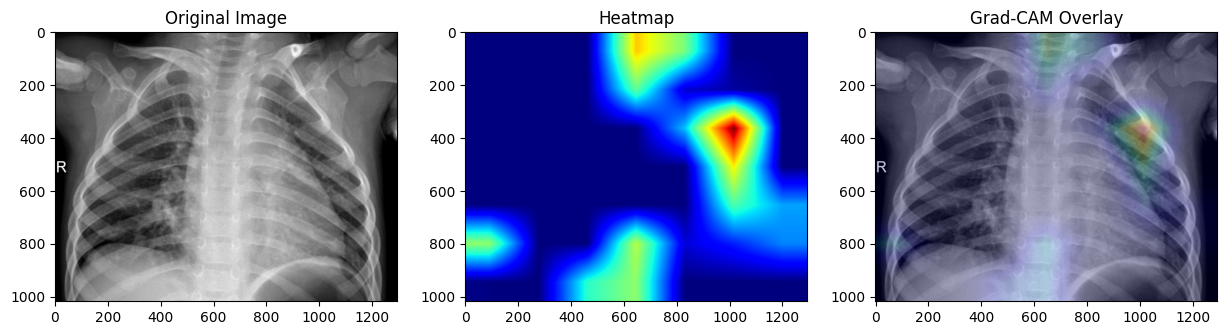

In [ ]:
# reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Register hooks
        self.gradients = None
        self.activations = None
        self.forward_hook_handle = self.target_layer.register_forward_hook(self.forward_hook)
        self.backward_hook_handle = self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = F.relu(output).clone()

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, image_path, resize_to=(224, 224)):
        # Load and preprocess the image
        image = np.array(Image.open(image_path).convert('RGB'))
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(resize_to),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        transformed_img = transform(image).to(self.device)
        input_img = Variable(transformed_img.unsqueeze(0), requires_grad=True)

        # Forward and backward pass to compute gradients and activations
        self.model.eval()
        output = self.model(input_img)
        output[:, torch.argmax(output)].backward()

        # Pool the gradients across the channels
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight the channels by corresponding gradients
        for i in range(self.activations.size()[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(self.activations, dim=1).squeeze()

        # ReLU on top of the heatmap
        heatmap = F.relu(heatmap)

        # Normalize the heatmap
        heatmap /= torch.max(heatmap)

        # Resize the heatmap to match the size of the original image
        heatmap_resized = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0),
                                         size=(image.shape[0], image.shape[1]),
                                         mode='bilinear', align_corners=False).squeeze()

        # Move the heatmap to the CPU before converting to NumPy
        heatmap_resized_cpu = heatmap_resized.cpu().detach().numpy()

        return heatmap_resized_cpu

    def display_overlay(self, original_image, heatmap, alpha=0.4):
        plt.figure(figsize=(15, 5))

        # Plot the original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title('Original Image')

        # Plot the heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet', interpolation='bilinear')
        plt.title('Heatmap')

        # Overlay Grad-CAM heatmap on the original image
        plt.subplot(1, 3, 3)
        cmap = colormaps['jet']
        overlay = (255 * cmap(np.asarray(heatmap) ** 2)[:, :, :3]).astype(np.uint8)
        plt.imshow(original_image)
        plt.imshow(overlay, alpha=0.2, cmap='jet', interpolation='bilinear')
        plt.title('Grad-CAM Overlay')

        plt.show()

    def close_hooks(self):
        # Unregister hooks
        self.forward_hook_handle.remove()
        self.backward_hook_handle.remove()


model = VGG19().to(DEVICE)
target_layer = model.vgg19.features[-1]  # Adjust the layer index based on your model architecture
grad_cam = GradCAM(model, target_layer)

image_path = '/content/chest_xray/train/PNEUMONIA/person996_bacteria_2924.jpeg'
heatmap = grad_cam.generate_heatmap(image_path)

# Display original image, heatmap, and overlay
original_image = np.array(Image.open(image_path).convert('RGB'))
grad_cam.display_overlay(original_image, heatmap)

# Close hooks to free

# ***Section 5***

This section will include the calling of all the above defined functions as training, evaluation and GRAD-CAM visualization.

## ***a. Call Functions***

### ***1. CNN***

#### ***1.1. Train Model***

In [ ]:
# Instantiate the CNNClassifier model
model = CNNClassifier(num_classes = 2)
model = model.to(DEVICE)
# epochs are only set to 1 as an example only (not the actual number the model was trained on)
epochs = 1
# Set the learning rate and optimizer
learning_rate = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
model, train_losses, test_losses, train_accuracies, test_accuracies, train_auc, test_auc = train_cnn(model, no_aug_train_data_loader, test_loader, criterion, learning_rate, optimizer, epochs=epochs)

In [ ]:
avg_metrics = validate(model, test_loader, criterion)
#print("Average Loss:", avg_metrics[0]*100,"%")
print("Average Accuracy:", avg_metrics[1]*100,"%")
print("Average AUC:", avg_metrics[2]*100,"%")

In [ ]:
print('CNN Train Losses: ', train_losses)
print('CNN Test Losses: ', test_losses)

plot_metrics(epochs, train_losses, test_losses, "Losses")

In [ ]:
print('CNN Train Accuracies: ', train_accuracies)
print('CNN Test Accuracies: ', test_accuracies)

plot_metrics(epochs, train_accuracies, test_accuracies, "Accuracies")

In [ ]:
print('CNN Train AUC: ', train_auc)
print('CNN Test AUC: ', test_auc)

plot_metrics(epochs, train_auc, test_auc, "AUC")

#### ***1.2. GRAD-CAM***

In [ ]:
conv_model = CNNLastConvLayerModel()
parameters = [conv_model, 150]
grad_cam(parameters)

### ***2. VGG19***

#### ***2.1. Train Model***

In [ ]:
EPOCHES = 20
mo= 0.9
model = VGG19(num_classes=2).to(DEVICE)
epochs = 50
# Set the learning rate and optimizer
learning_rate = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
# Use the modified training function
model, train_losses, test_losses, train_accuracies, test_accuracies, train_auc, test_auc  = train_vgg19(model, no_aug_train_data_loader,test_loader, criterion, optimizer, EPOCHES)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 99.4MB/s]


Training Epoch [0/19]
Training Epoch [1/19]
Training Epoch [2/19]
Training Epoch [3/19]
Training Epoch [4/19]
Training Epoch [5/19]
Training Epoch [6/19]
Training Epoch [7/19]
Training Epoch [8/19]
Training Epoch [9/19]
Training Epoch [10/19]
Training Epoch [11/19]
Training Epoch [12/19]
Training Epoch [13/19]
Training Epoch [14/19]
Training Epoch [15/19]
Training Epoch [16/19]
Training Epoch [17/19]
Training Epoch [18/19]
Training Epoch [19/19]
Evaluating Test Loss For Epoch [0/19]
Evaluating Test Loss For Epoch [1/19]
Evaluating Test Loss For Epoch [2/19]
Evaluating Test Loss For Epoch [3/19]
Evaluating Test Loss For Epoch [4/19]
Evaluating Test Loss For Epoch [5/19]
Evaluating Test Loss For Epoch [6/19]
Evaluating Test Loss For Epoch [7/19]
Evaluating Test Loss For Epoch [8/19]
Evaluating Test Loss For Epoch [9/19]
Evaluating Test Loss For Epoch [10/19]
Evaluating Test Loss For Epoch [11/19]
Evaluating Test Loss For Epoch [12/19]
Evaluating Test Loss For Epoch [13/19]
Evaluating Tes

In [ ]:
avg_metrics = validate(model, test_loader, criterion)
#print("Average Loss:", avg_metrics[0]*100,"%")
print("Average Accuracy:", avg_metrics[1]*100,"%")
print("Average AUC:", avg_metrics[2]*100,"%")

Average Accuracy: 80.76923076923077 %
Average AUC: 93.35000015688534 %


VGG19 Train Losses:  [0.4328704424407504, 0.18166949488336523, 0.12910946611804883, 0.10783138897964896, 0.08958791413085268, 0.07257298129505338, 0.06005879151649112, 0.053787790022403095, 0.04753185720083272, 0.04149986994210687, 0.03347299825731204, 0.030815404128861423, 0.02574018010690193, 0.022635221367756003, 0.01911168311496866, 0.016778382042900657, 0.013437085625701669, 0.011685452474565466, 0.008754085371705465, 0.006439211970682775]
VGG19 Test Losses:  [1.1906482057693677, 1.1906482195242858, 1.190648195071098, 1.1906482546757429, 1.1906482072976918, 1.1906481744387212, 1.1906481862832339, 1.1906482179959614, 1.1906482317508795, 1.1906482256375825, 1.190648195071098, 1.190648201184395, 1.1906482057693677, 1.1906481859011528, 1.1906482164676373, 1.1906482042410436, 1.1906482248734205, 1.1906482195242858, 1.1906481988919086, 1.1906482057693677]


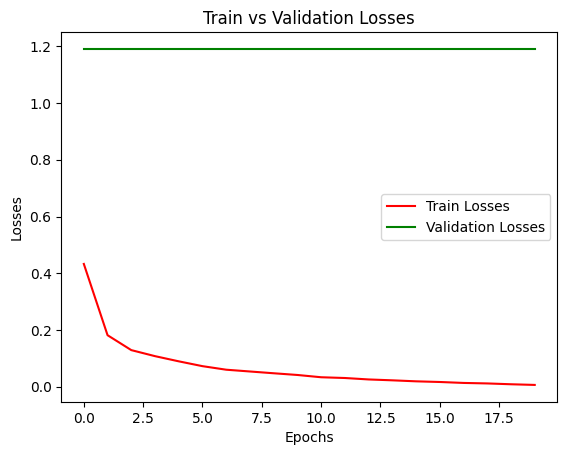

In [ ]:
print('VGG19 Train Losses: ', train_losses)
print('VGG19 Test Losses: ', test_losses)

plot_metrics(EPOCHES, train_losses, test_losses, "Losses")

VGG19 Train Accuracies:  [0.8021788990825688, 0.9294724770642202, 0.9512614678899083, 0.9600535168195719, 0.9690366972477065, 0.9747706422018348, 0.9784021406727829, 0.9810779816513762, 0.9841360856269113, 0.9845183486238532, 0.9877675840978594, 0.9892966360856269, 0.9908256880733946, 0.992545871559633, 0.9929281345565749, 0.9936926605504587, 0.9957951070336392, 0.996177370030581, 0.9967507645259939, 0.9977064220183486]
VGG19 Test Accuracies:  [0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077, 0.8076923076923077]


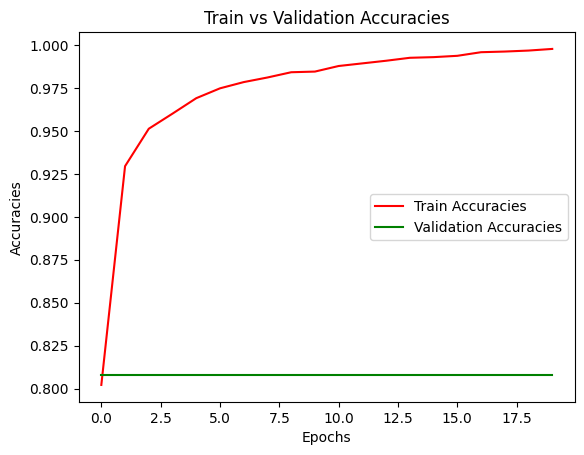

In [ ]:
print('VGG19 Train Accuracies: ', train_accuracies)
print('VGG19 Test Accuracies: ', test_accuracies)

plot_metrics(EPOCHES, train_accuracies, test_accuracies, "Accuracies")

In [ ]:
print('VGG19 Train AUC: ', train_auc)
print('VGG19 Test AUC: ', test_auc)

plot_metrics(EPOCHES, train_auc, test_auc, "AUC")

#### ***3. VGG16*** ###

### ***3.1 Train Model***

In [ ]:
EPOCHES = 20
mo= 0.9
model = VGG16(num_classes=2).to(DEVICE)
epochs = 50
# Set the learning rate and optimizer
learning_rate = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
# Use the modified training function
model, train_losses, test_losses, train_accuracies, test_accuracies, train_auc, test_auc = train_vgg19(model, no_aug_train_data_loader,test_loader, criterion, optimizer, EPOCHES)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 79.0MB/s]


Training Epoch [0/19]
Training Epoch [1/19]
Training Epoch [2/19]
Training Epoch [3/19]
Training Epoch [4/19]
Training Epoch [5/19]
Training Epoch [6/19]
Training Epoch [7/19]
Training Epoch [8/19]
Training Epoch [9/19]
Training Epoch [10/19]
Training Epoch [11/19]
Training Epoch [12/19]
Training Epoch [13/19]
Training Epoch [14/19]
Training Epoch [15/19]
Training Epoch [16/19]
Training Epoch [17/19]
Training Epoch [18/19]
Training Epoch [19/19]
Evaluating Test Loss For Epoch [0/19]
Evaluating Test Loss For Epoch [1/19]
Evaluating Test Loss For Epoch [2/19]
Evaluating Test Loss For Epoch [3/19]
Evaluating Test Loss For Epoch [4/19]
Evaluating Test Loss For Epoch [5/19]
Evaluating Test Loss For Epoch [6/19]
Evaluating Test Loss For Epoch [7/19]
Evaluating Test Loss For Epoch [8/19]
Evaluating Test Loss For Epoch [9/19]
Evaluating Test Loss For Epoch [10/19]
Evaluating Test Loss For Epoch [11/19]
Evaluating Test Loss For Epoch [12/19]
Evaluating Test Loss For Epoch [13/19]
Evaluating Tes

In [ ]:
avg_metrics = validate(model, test_loader, criterion)
#print("Average Loss:", avg_metrics[0]*100,"%")
print("Average Accuracy:", avg_metrics[1]*100,"%")
print("Average AUC:", avg_metrics[2]*100,"%")

Average Accuracy: 81.89102564102564 %
Average AUC: 95.27990715875502 %


VGG16 Train Losses:  [0.5073892344757687, 0.22038055919908237, 0.1464575810944633, 0.11231382870163757, 0.09068238893552293, 0.07869679879237661, 0.0674883461534544, 0.05688356647455911, 0.05403472801431193, 0.04375296654977155, 0.03956616208397296, 0.03422376469763093, 0.030576526556542822, 0.02568532929211764, 0.023347909512448292, 0.02037459138701798, 0.01786533279849262, 0.014679051779206295, 0.01290486850551492, 0.01176423317982761]
VGG16 Test Losses:  [0.8715272079675626, 0.871527224014967, 0.871527224014967, 0.8715272026064877, 0.871527204146752, 0.871527200516982, 0.87152721790167, 0.8715272316565881, 0.8715272301282638, 0.8715272087317246, 0.8715272484681545, 0.8715272255432911, 0.8715272201941564, 0.8715271995617793, 0.8715272400623713, 0.8715272373878039, 0.8715272222000819, 0.8715272032631896, 0.8715272102600489, 0.8715272133166974]


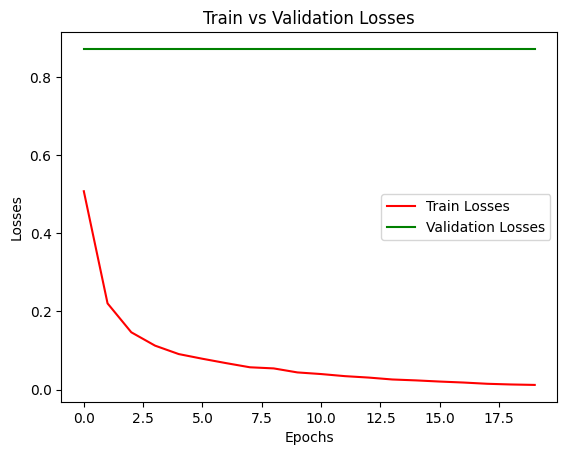

In [ ]:
print('VGG16 Train Losses: ', train_losses)
print('VGG16 Test Losses: ', test_losses)

plot_metrics(EPOCHES, train_losses, test_losses, "Losses")

VGG16 Train Accuracies:  [0.7521024464831805, 0.91532874617737, 0.9476299694189603, 0.95967125382263, 0.9675076452599388, 0.9715214067278287, 0.9759174311926605, 0.9795489296636085, 0.9808868501529052, 0.9835626911314985, 0.9871941896024465, 0.9881498470948012, 0.989105504587156, 0.9929281345565749, 0.9940749235474006, 0.9929281345565749, 0.9933103975535168, 0.9959862385321101, 0.996177370030581, 0.9969418960244648]
VGG16 Test Accuracies:  [0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564, 0.8189102564102564]


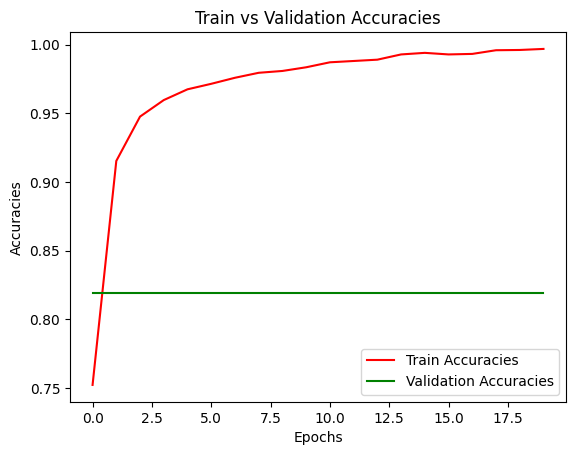

In [ ]:
print('VGG16 Train Accuracies: ', train_accuracies)
print('VGG16 Test Accuracies: ', test_accuracies)

plot_metrics(EPOCHES, train_accuracies, test_accuracies, "Accuracies")

In [ ]:
print('VGG16 Train AUC: ', train_auc)
print('VGG16 Test AUC: ', test_auc)

plot_metrics(EPOCHES, train_auc, test_auc, "AUC")

### ***3.2 GRAD-CAM***

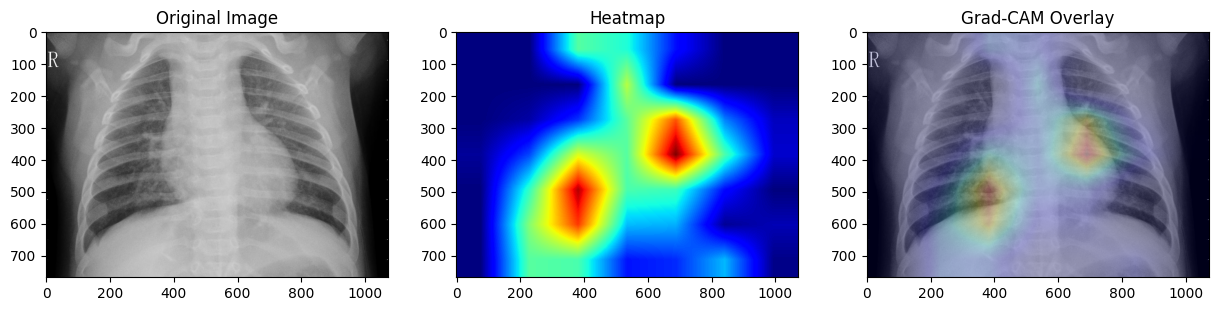

In [ ]:
model = VGG16().to(DEVICE)
target_layer = model.vgg16.features[-1]  # Adjust the layer index based on your model architecture
grad_cam = GradCAM(model, target_layer)

image_path = '/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'
heatmap = grad_cam.generate_heatmap(image_path)

# Display original image, heatmap, and overlay
original_image = np.array(Image.open(image_path).convert('RGB'))
grad_cam.display_overlay(original_image, heatmap)

# Close hooks to free

### ***4. MobileNetV2***

In [ ]:
# Create and train the model
model = CustomMobileNetV2(num_classes= 2)
trained_model = train_mobilenet_model(model, no_aug_train_data_loader, test_loader)

### ***5. RESNET50***

In [ ]:
resnet50_model = train_resnet50(train_loader)